In [1]:
from __future__ import print_function, division
import torch
from PIL import Image
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import transforms
from tensorflow.keras.applications.efficientnet import decode_predictions

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
cvmodel = model
cvmodel.eval()
feat_exp = create_feature_extractor(cvmodel, return_nodes=['avgpool'])
fc = model.fc
model.eval()
feat_exp.eval()
cvmodel.eval()

In [3]:
sam_checkpoint = "./Models/pretrained/sam_vit_h_4b8939.pth" # Adapt Path to SAM checkpoint

model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam,
                                           min_mask_region_area=512,
                                            points_per_side=32,
                                            )



FileNotFoundError: [Errno 2] No such file or directory: './Models/pretrained/sam_vit_h_4b8939.pth'

In [ ]:
test_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) ### a complete imagenet data pre-process

image_reshape = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
]) ### process the imagenet data to sam

image_norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) ### imagenet std and mean

class ImageModel:
    def __init__(self, model, test_preprocess):
        self.model = model
        self.test_preprocess = test_preprocess
        
    def predict (self, image_data):
        first_dim = 1 if len(image_data.shape) == 3 else len(image_data)
        image_data = image_data.reshape(first_dim, image_data.shape[1], image_data.shape[2], 3)
        
        # Convert numpy array to PIL Images
        image_data_pil = [Image.fromarray(local_img) for local_img in image_data]
        # Apply preprocessing
        preprocessed_images = [test_preprocess(img).unsqueeze(0) for img in image_data_pil]
        
        # Stack preprocessed images into a batch tensor
        batch_tensor = torch.cat(preprocessed_images, dim=0)
        
        # Pass the batch tensor through the model
        scores = self.model(batch_tensor)
        return scores
    
image_model = ImageModel(model, test_preprocess)
def lime_explanation_function(images):
    scores = image_model.predict(images)
    scores_np = scores.detach().numpy()
    return scores_np

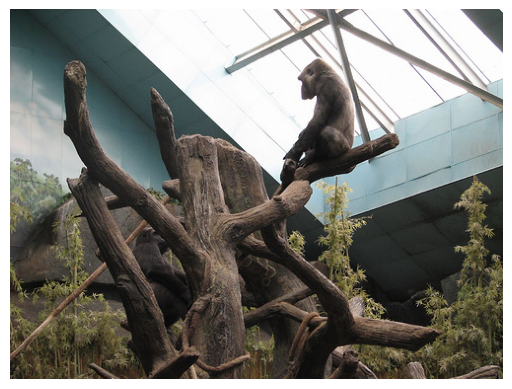

torch.Size([1, 1000])

In [5]:
img_path = "./Dataset/Evaluation/n02480855_gorilla.JPEG"
img = Image.open(img_path).convert('RGB')

plt.imshow(img)
plt.axis(False)
plt.show()
plt.close()

predict_org = torch.nn.functional.softmax(model(test_preprocess(img).unsqueeze(0)),dim=1)
predict_org.shape



In [6]:
arg_position = 1
pred_image_class = torch.sort(predict_org, descending=True).indices[0][arg_position].item()
label_class = decode_predictions(predict_org.detach().numpy().reshape(1, -1))
print(label_class)
print(pred_image_class)

[[('n02480855', 'gorilla', 0.8622205), ('n02486410', 'baboon', 0.070670694), ('n02488291', 'langur', 0.019563176), ('n02483362', 'gibbon', 0.018854497), ('n02487347', 'macaque', 0.011691794)]]
372


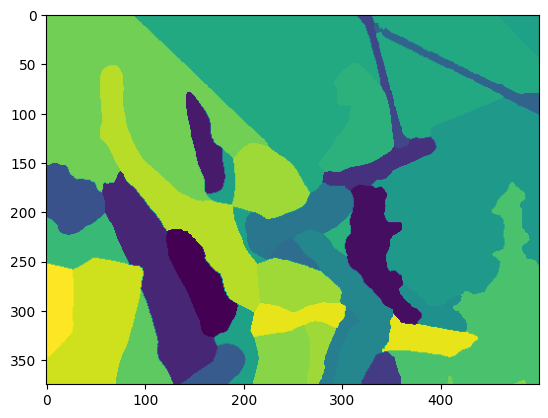

  0%|          | 0/256 [00:00<?, ?it/s]

In [7]:
from Utilities.dseg_lime import DSEG_Lime

explainer = DSEG_Lime()
img = Image.open(img_path).convert('RGB')
for_mask_image = np.array((img)) 
explanation = explainer.explain_instance(image = for_mask_image, 
                                        classifier_fn=lime_explanation_function,
                                        feature_extractor=mask_generator,
                                        model = sam,
                                        image_path = img_path,
                                        iterations = 1)


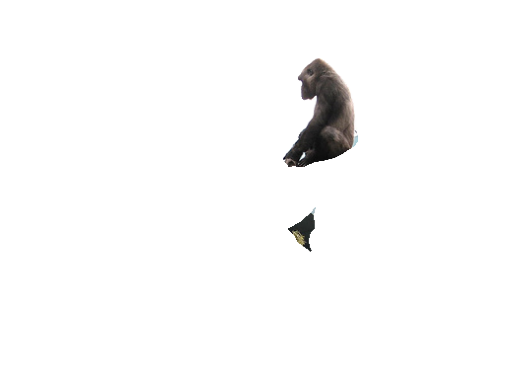

In [8]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=1, hide_rest=True)
# Convert mask to 3D
mask_3d = np.stack([mask] * 3, axis=-1)
# Create a white background image
white_background = np.ones_like(np.array(for_mask_image)) * 255 
# Blend the original image with the white background using the mask
image_with_mask = np.where(mask_3d, np.array(for_mask_image), white_background)
# Display the image with boundaries
plt.imshow(image_with_mask)
plt.axis(False)
plt.show()